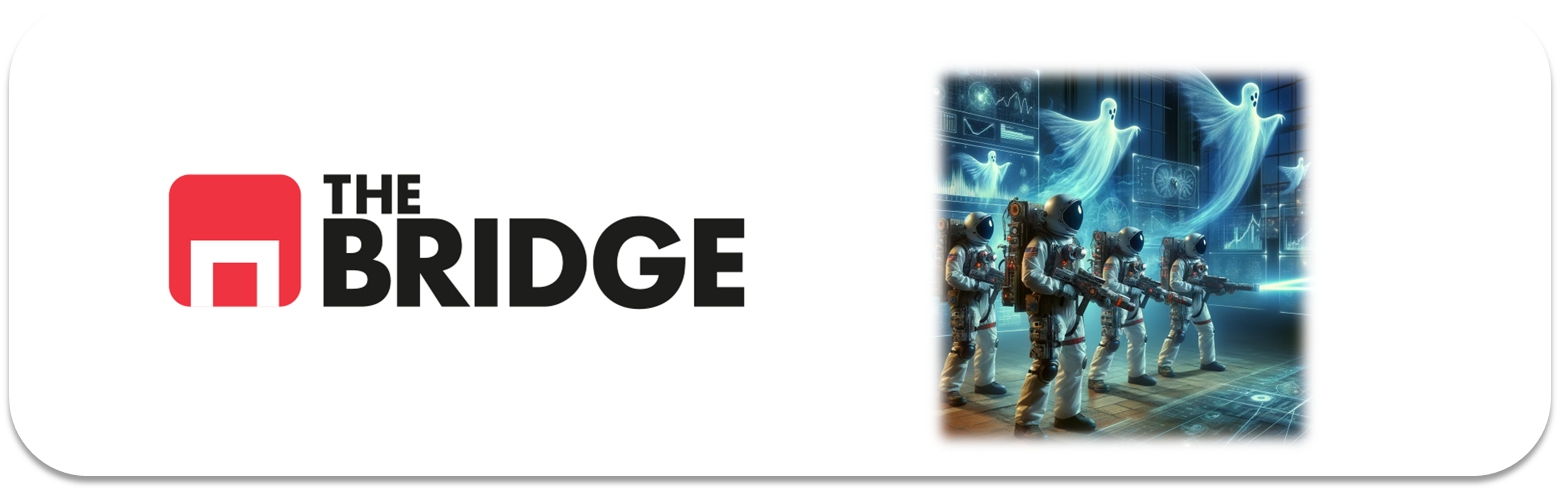

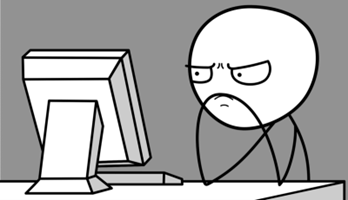

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [58]:
df = pd.read_csv("./data/AirPassengers.csv")
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [60]:
#df["date"] = pd.to_datetime(df["date"])

#df = df.sort_values("date").set_index("date")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [62]:
# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# Crear una columna para el año y el mes
#df['year_month'] = df["date"].dt.to_period('M')

# Contar los días únicos en cada mes
#days_per_month = df.groupby('year_month')["date"].nunique()

# Filtrar los meses con varios días
#months_with_multiple_days = days_per_month[days_per_month > 1]

#print(months_with_multiple_days)

In [63]:
df = df.sort_values("date").set_index("date")

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

In [65]:
df.sort_values(by='date')

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


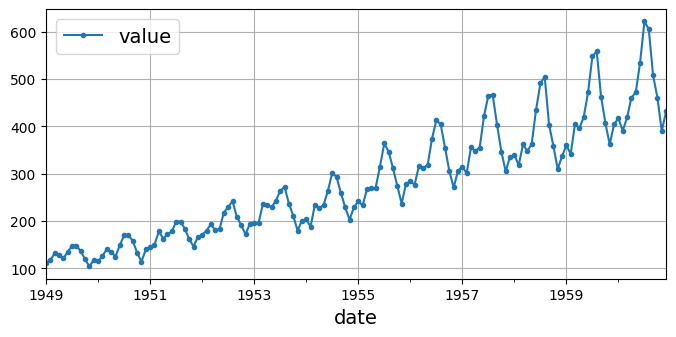

In [66]:
comienzo = "1949-01"
fin = "1960-12"

df[comienzo:fin].plot(grid=True, marker=".", figsize=(8,3.5));

In [67]:
#periodicidad mensual, los datos son mensuales


### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

In [68]:
diff_12 = df["value"].diff(12)[comienzo:fin] # Diferenciamos

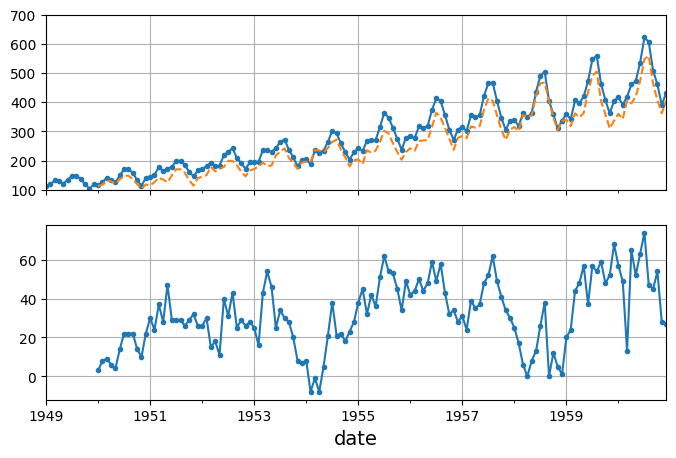

In [69]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df[comienzo:fin].plot(ax=axs[0], legend=False, marker=".")  # original time series
df[comienzo:fin].shift(12).plot(ax=axs[0], grid=True, legend=False, linestyle="--")  # lagged
diff_12.plot(ax=axs[1], grid=True, marker=".")  # 12-meses difference time series
axs[0].set_ylim([100, 700]) 
plt.show()

In [70]:
# Las series temporales retrasadas en 1 año se superponen en forma pero con incremento, en 1954 y 1958 no ha subida
list(df.loc["1953-01-01":"1954-06-01"]["value"]) # sept 1953-nov1954 

[196,
 196,
 236,
 235,
 229,
 243,
 264,
 272,
 237,
 211,
 180,
 201,
 204,
 188,
 235,
 227,
 234,
 264]

In [71]:
targets = df["value"]["1953-09-01":"1954-11-01"]
((diff_12 / targets).abs().mean())*100 # hay un decrecimiento de 6.59% en la prediccion respecto al año anterior

6.5915022373195

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

In [76]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


In [72]:
df["1950-01":"1960-12"]

,value
date,
1950-01-01,115
1950-02-01,126
1950-03-01,141
1950-04-01,135
1950-05-01,125
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


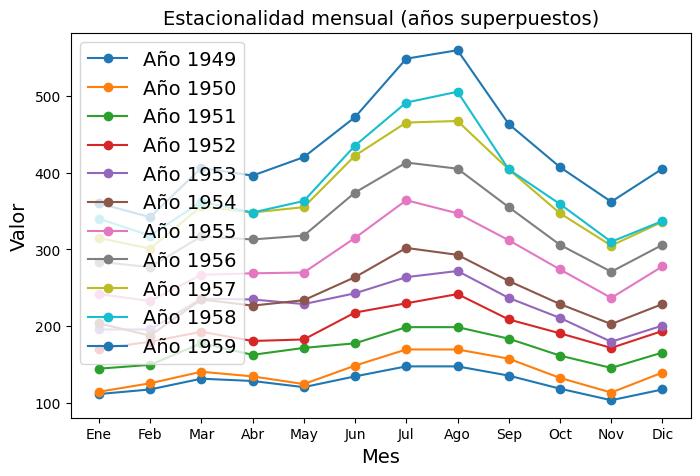

In [81]:
# Estacionalidad mensual, pintamos los meses superpuestos del periodo 1955-1958:
import pandas as pd
import matplotlib.pyplot as plt

# Crear la figura con un solo eje
fig, ax = plt.subplots(figsize=(8, 5))

# Graficar los datos de cada año superpuestos
for year in range(1949, 1960):
    datos_anuales = df.loc[(df.index >= f"{year}-01-01") & (df.index <= f"{year}-12-01")]
    if not datos_anuales.empty:
        ax.plot(datos_anuales.index.month, datos_anuales["value"], label=f"Año {year}", marker='o')

# Etiquetas y leyenda
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
ax.set_xlabel("Mes")
ax.set_ylabel("Valor")
ax.set_title("Estacionalidad mensual (años superpuestos)")
ax.legend()

plt.show()



### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

In [90]:
period = slice("1949", "1959")
df_anual = df[["value"]].resample("YE").mean()
rolling_average_anual = df[period].rolling(window=12).mean()

In [91]:
df_anual

,value
date,
1949-12-31,126.666667
1950-12-31,139.666667
1951-12-31,170.166667
1952-12-31,197.000000
1953-12-31,225.000000
1954-12-31,238.916667
1955-12-31,284.000000
1956-12-31,328.250000
1957-12-31,368.416667


In [95]:
df["1960-01-01":"1960-12-01"]["value"].mean()

476.1666666666667

In [96]:
rolling_average_anual["1949-01-01":"1960-12-01"]

,value
date,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1959-08-01,409.416667
1959-09-01,414.333333
1959-10-01,418.333333


In [97]:
df_anual["1949-01-01":"1960-12-01"].mean()

value    262.492424
dtype: float64

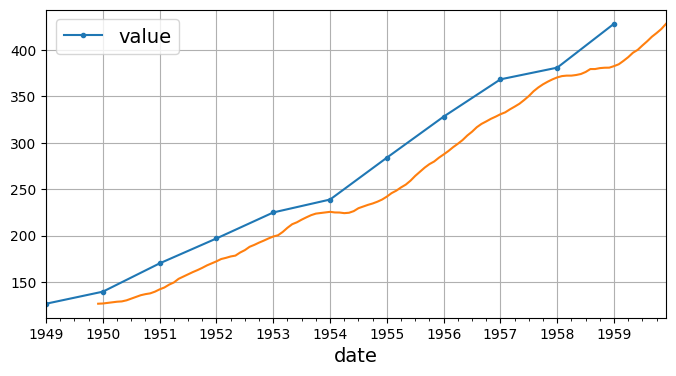

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))
df_anual[period].plot(ax=ax, marker=".")
rolling_average_anual.plot(ax=ax, grid=True, legend=False)
# extra code – saves the figure for the book
plt.show()

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

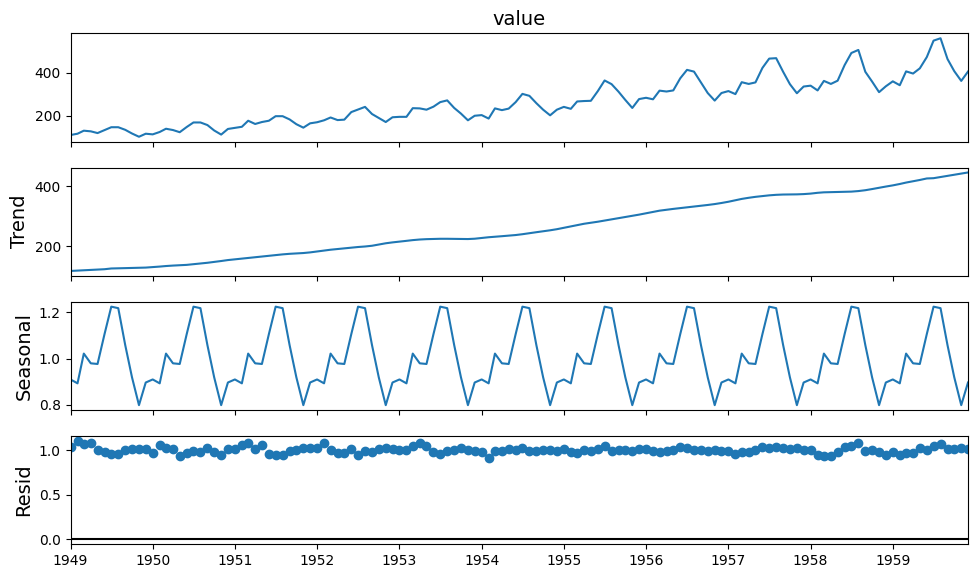

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df["1949":"1959"]["value"], model = 'multiplicative', 
                                extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df["1949":"1959"]['value'], model = 'additive', 
                                extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
result_mul.plot();

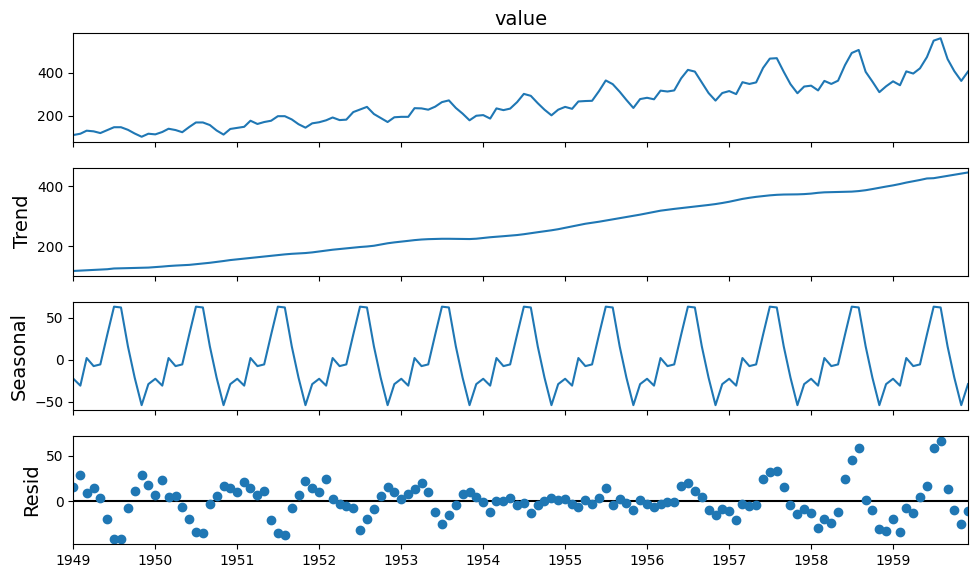

In [103]:
result_add.plot();

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

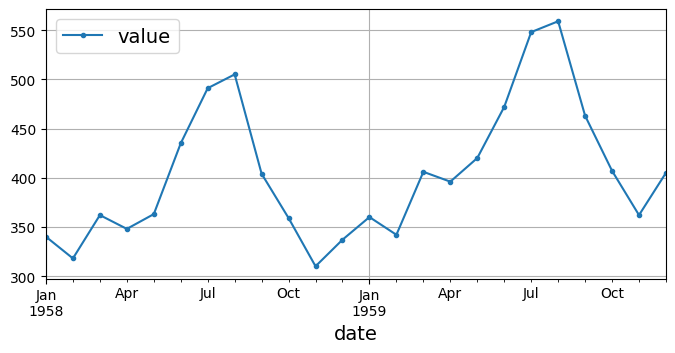

In [126]:
df["1958-01-01":"1959-12-01"].plot(grid=True, marker=".", figsize=(8,3.5));

In [ ]:
# Filtrar el DataFrame para obtener los últimos 24 meses a partir de diciembre de 1959
df_filtered = df.loc['1958-01-01':'1959-12-01']

# Crear el DataFrame con desplazamientos (shifts) desde 1 hasta 24 meses
df_shifted = pd.DataFrame()
# Agregar la columna original
df_shifted['original'] = df_filtered['value']
for i in range(1, 24):
    df_shifted[f'shift_{i}'] = df_filtered['value'].shift(i)


In [123]:
df_shifted

,original,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23
date,,,,,,,,,,,,,,,,,,,,,
1958-01-01,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-02-01,318,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-03-01,362,318.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-04-01,348,362.0,318.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-05-01,363,348.0,362.0,318.0,340.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-06-01,435,363.0,348.0,362.0,318.0,340.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-07-01,491,435.0,363.0,348.0,362.0,318.0,340.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-08-01,505,491.0,435.0,363.0,348.0,362.0,318.0,340.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-09-01,404,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# Calcular la matriz de correlación
correlation_matrix = df_shifted.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)


          original   shift_1   shift_2   shift_3   shift_4   shift_5  \
original  1.000000  0.742789  0.309303 -0.102413 -0.330836 -0.437572   
shift_1   0.742789  1.000000  0.748141  0.309399 -0.098885 -0.355935   
shift_2   0.309303  0.748141  1.000000  0.755943  0.347180 -0.017854   
shift_3  -0.102413  0.309399  0.755943  1.000000  0.769152  0.410652   
shift_4  -0.330836 -0.098885  0.347180  0.769152  1.000000  0.798232   
shift_5  -0.437572 -0.355935 -0.017854  0.410652  0.798232  1.000000   
shift_6  -0.522104 -0.489326 -0.307655  0.000686  0.391607  0.727958   
shift_7  -0.398719 -0.542021 -0.455733 -0.311897 -0.059155  0.262724   
shift_8  -0.279621 -0.398887 -0.525647 -0.452868 -0.345448 -0.168017   
shift_9  -0.009669 -0.279218 -0.392694 -0.523593 -0.468436 -0.439610   
shift_10  0.300302 -0.007438 -0.262530 -0.390615 -0.550579 -0.612346   
shift_11  0.699069  0.299259 -0.038592 -0.270167 -0.374437 -0.546237   
shift_12  0.980656  0.697347  0.287518 -0.041234 -0.258140 -0.38

In [125]:
# Extraer la correlación con la columna original
correlation_with_original = correlation_matrix['original']

# Imprimir la correlación con la columna original
print(correlation_with_original)


original    1.000000
shift_1     0.742789
shift_2     0.309303
shift_3    -0.102413
shift_4    -0.330836
shift_5    -0.437572
shift_6    -0.522104
shift_7    -0.398719
shift_8    -0.279621
shift_9    -0.009669
shift_10    0.300302
shift_11    0.699069
shift_12    0.980656
shift_13    0.706451
shift_14    0.129195
shift_15   -0.466521
shift_16   -0.677675
shift_17   -0.675365
shift_18   -0.598407
shift_19   -0.468970
shift_20   -0.447890
shift_21    0.845688
shift_22   -1.000000
shift_23         NaN
Name: original, dtype: float64


La matriz de correlación muestra la relación entre el valor actual (original) y los valores desplazados (de shift_1 a shift_23). Aquí hay algunos puntos clave:

Autocorrelación positiva:

shift_1: 0.742789 (alta correlación)

shift_11: 0.699069 (alta correlación)

shift_12: 0.980656 (muy alta correlación)

shift_13: 0.706451 (alta correlación)

shift_21: 0.845688 (alta correlación)

Esto sugiere que hay una fuerte estacionalidad anual (12 meses), ya que la correlación con shift_12 es muy alta. También hay correlaciones significativas en shift_1, shift_11, shift_13 y shift_21, indicando posibles patrones estacionales o tendencias a corto plazo.

Autocorrelación negativa:

shift_5: -0.437572

shift_15: -0.466521

shift_16: -0.677675

shift_17: -0.675365

shift_18: -0.598407

shift_19: -0.468970

shift_20: -0.447890

shift_22: -1.000000

Estas correlaciones negativas pueden indicar ciclos de estacionalidad a más corto plazo o periodos en los que los valores tienden a ser más bajos en relación con los valores desplazados. La correlación de -1.0 en shift_22 es inusual y podría necesitar una revisión más profunda.

Correlaciones cercanas a cero:

shift_3, shift_4, shift_8, shift_9, shift_10, shift_14, etc.

Estas correlaciones cercanas a cero indican que no hay una relación clara entre el valor actual y los valores desplazados en esos períodos.

En resumen, la alta correlación en shift_12 confirma una estacionalidad anual clara. Las altas correlaciones en shift_1 y shift_11 también sugieren tendencias a corto plazo. Las correlaciones negativas en shift_15 a shift_20 podrían indicar ciclos estacionales más cortos o fluctuaciones en los datos.

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

# Hay seasonality anual
La estacionalidad o "seasonality" que hemos identificado se observa principalmente en la alta correlación en shift_12, que indica una fuerte relación entre los valores actuales y los valores de hace 12 meses. Esto sugiere un patrón estacional anual, donde los valores tienden a repetirse o ser similares cada 12 meses.

Para resumir:

Alta correlación en shift_12 (0.980656): Indica que hay una estacionalidad anual (cada 12 meses).

Otras correlaciones significativas en shift_11 y shift_13: Esto también refuerza la idea de un ciclo anual, ya que los valores están muy cerca de 12 meses.

La correlación extremadamente alta en shift_12 implica que el patrón se repite aproximadamente cada 12 meses. Este es un indicador claro de estacionalidad anual.



### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [134]:
X_train = df.loc[:df.index[-21]]  # Hasta 21 registros antes del final
X_test = df.loc[df.index[-20]:]  # Últimos 20 registros






In [135]:
X_train

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-12-01,337
1959-01-01,360
1959-02-01,342


In [136]:
X_test

,value
date,
1959-05-01,420
1959-06-01,472
1959-07-01,548
1959-08-01,559
1959-09-01,463
1959-10-01,407
1959-11-01,362
1959-12-01,405
1960-01-01,417


### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [147]:
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ARIMA

value_series_train =X_train["value"].asfreq("MS") 
# asfreq sirve para indicar la frecuencia de los datos y facilitarle la tarea a 
# los modelos, en este caso MS MENSUAL START



In [148]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
print("Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones:",
      len(pdq))
pdq[:10] # Solo los primeros 10 elementos 

Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones: 125


[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [149]:
results = []
for param in pdq:
    try: # Por si alguna combinación "no tiene sentido"
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(value_series_train)
        results.append((param,model_arima_fit.aic())) 
        # obtenemos el AIC por combinación
    except:
        results.append((param,999999999)) 
        # Si no tiene sentido ponemos un código especial
        continue

c:\Users\josel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\josel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\josel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\josel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

In [150]:
resultados_df = pd.DataFrame(results, 
                             columns=['ARIMA params',
                                      'AIC']).sort_values('AIC',ascending= True)
resultados_df.head(125)

,ARIMA params,AIC
83,"(3, 1, 3)",1119.169870
114,"(4, 2, 4)",1123.990038
108,"(4, 1, 3)",1127.984599
34,"(1, 1, 4)",1132.319489
107,"(4, 1, 2)",1134.574055
...,...,...
70,"(2, 4, 0)",1324.039577
1,"(0, 0, 1)",1342.004538
45,"(1, 4, 0)",1380.651046
20,"(0, 4, 0)",1440.701536


In [157]:
from pmdarima.arima import auto_arima

model = auto_arima(value_series_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace= True,
                   stepwise = True) # Está a True por defecto

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1180.340, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1174.338, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1171.576, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1179.124, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1164.464, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1171.757, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1163.079, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1170.015, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1172.799, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1156.122, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1170.365, T

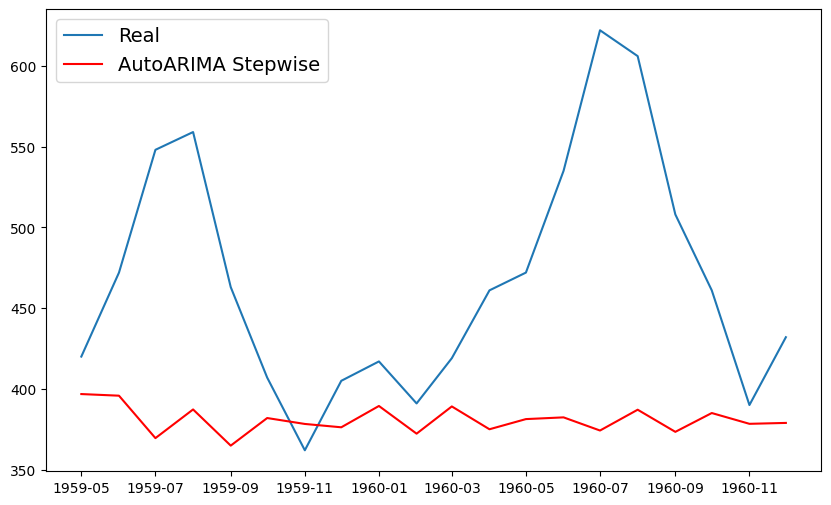

In [158]:
y_pred = model.predict(20)
plt.plot(X_test, label = "Real")
plt.plot(y_pred,color='red', label = "AutoARIMA Stepwise")
plt.legend()

In [159]:
print("RMSE:", np.sqrt(mean_squared_error(X_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(X_test, y_pred) * 100)

RMSE: 113.15708510976437
MAPE: 17.15081486602256


### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [163]:
model = auto_arima(value_series_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   m = 12,
                   trace= True,
                   stepwise = False)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=942.581, Time=0.01 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=944.471, Time=0.14 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=946.468, Time=0.27 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=944.471, Time=0.32 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=946.470, Time=0.21 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=948.468, Time=0.45 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=946.471, Time=0.43 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=948.469, Time=0.42 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=889.425, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=890.316, Time=0.15 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=892.265, Time=0.45 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=890.384, Time=0.21 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=892.272, Time=0.39 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=894.265, Time=0.42 sec
 ARIMA(0,0,1)(

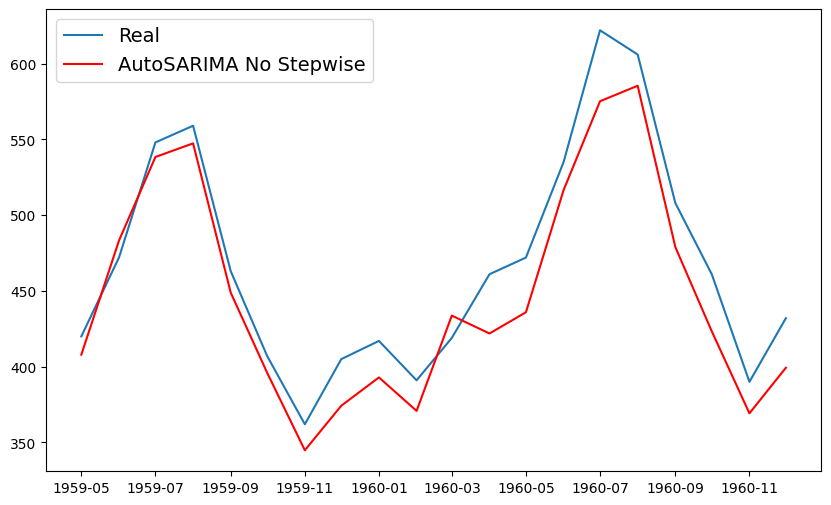

In [164]:
y_pred = model.predict(20)
plt.plot(X_test, label = "Real")
plt.plot(y_pred,color='red', label = "AutoSARIMA No Stepwise")
plt.legend()

In [165]:
print("RMSE:", np.sqrt(mean_squared_error(X_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(X_test, y_pred) * 100)

RMSE: 25.32068100593451
MAPE: 4.9476752227069785
